In [12]:
import sys
sys.path.append('../')
from itertools import combinations

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pprint import pprint

from sklearn.manifold import TSNE
from sklearn.metrics import pairwise_distances as pdist
import gensim
from tmtoolkit.topicmod.evaluate import *

from lyricpsych.data import *
from lyricpsych.utils import *
from lyricpsych.embeddings import *
from lyricpsych.topic_model import PLSA, _learn_doc_topic, get_top_terms

In [4]:
# Loading data
raw_data = load_lyrics_db('/hdd/data/mxm_lyrics_30p/')
_, _, tid_map, _ = load_mxm_bow('/hdd/mxm_dataset_train.txt')
mxm2msd = {mxm:msd for msd, mxm in tid_map.items()}

tracks = pd.read_csv('/hdd/data/unique_tracks.txt', sep='<SEP>', header=None)

raw_data = filter_english_plsa(raw_data)
# data = preprocessing([r[1] for r in raw_data], 'unigram', [5, 0.3])
# data = {'corpus':data[0], 'id2word':data[1], 'X':data[2]}

In [73]:
def calculate_coherence( w2v_model, term_rankings ):
    """ Compute coherence
    
    It's from 
    https://github.com/derekgreene/topic-model-tutorial/blob/master/3%20-%20Parameter%20Selection%20for%20NMF.ipynb
    """
    overall_coherence = np.zeros(len(term_rankings))
    for kk, topic_index in enumerate(range(len(term_rankings))):
        # check each pair of terms
        pair_scores = []
        for pair in combinations( term_rankings[topic_index], 2 ):
            try:
                pair_scores.append( w2v_model.similarity(pair[0], pair[1]) )
            except Exception as e:
                print(e)
        # get the mean for all pairs in this topic
        topic_score = sum(pair_scores) / len(pair_scores)
        overall_coherence[kk] += topic_score
    # get the mean score across all topics
    return overall_coherence


def coherence_Mimno11a(train_docs, term_rankings):
    coherence = np.zeros(len(term_rankings))
    W = train_docs.T.tocsr()  # term - doc matrix
    for kk, terms in enumerate(term_rankings):
        for i in range(1, len(terms)):
            vi = W[terms[i]].indices
            for j in range(i):
                vj = W[terms[j]].indices
                
                numer = len(set(vi).intersection(set(vj)))
                denom = len(vj)
                
                # cornercase
                if denom == 0:
                    continue

                coherence[kk] += np.log((numer + 1) / denom)
    return coherence

In [74]:
def discrete_kl(P, Q):
    return (P * np.log(np.maximum(P, 1e-10) / Q)).sum()

def plsa_junkness(plsa, Xtr):
    phi = plsa.topic_term
    theta = plsa.doc_topic
    N = phi.shape[1]
    M = theta.shape[0]
    K = plsa.k

#     mp = Xtr.sum(0).A.flatten()
#     mp = mp / mp.sum()

    uniform_term_junkness = np.mean([discrete_kl(phi[topic], np.full((N,), 1/N)) for topic in range(plsa.k)])
    # empirical_freq_term_junkness = np.mean([discrete_kl(phi[topic], mp) for topic in range(plsa.k)])
    uniform_doc_junkness = np.mean([discrete_kl(theta[i], np.full((K,), 1/K)) for i in range(M)])
    
    return (
        uniform_term_junkness,
#         empirical_freq_term_junkness,
        uniform_doc_junkness
    )

In [5]:
X = data['X'].copy().tocsr()
Xtr, Xts, trn_ix, tst_ix = split_docs(X, 0.8)

plsa = PLSA(25, 30)
plsa.fit(Xtr)

In [25]:
np.array([data['id2word'][i] for i in np.argsort(-plsa.topic_term[19])[:25]])

array(['time', 'got', 'see', 'going', 'let', 'feeling', 'right', 'keep',
       'something', 'go', 'better', 'wrong', 'lose', 'know', 'start',
       'long', 'eye', 'waiting', 'face', 'may', 'look', 'sometimes',
       'good', 'nothing', 'like'], dtype='<U9')

In [ ]:
for k in range(10, 100, 10):
    for n in range(20):
        X = data['X'].copy().tocsr()
        Xpen = X[-pennebaker_data.shape[0]:]
        Xlyr = X[:-pennebaker_data.shape[0]]
        Xtr, Xts, trn_ix, tst_ix = split_docs(Xlyr, 0.8)

        plsa = PLSA(k, 30)
        plsa.fit(Xtr)

        top_terms = [
            [data['id2word'].token2id[t] for t in tokens]
            for tokens in get_top_terms(plsa, data['id2word'])
        ]
        print(
            '{:d},{:d},{:.4f},{:.4f},{:.4f},{:.4f}'
            .format(k, n,
                    plsa.score(Xts) / Xts.shape[0],
                    plsa.score(Xpen) / Xpen.shape[0],
                    plsa_junkness(plsa, Xtr)[0],
                    coherence_Mimno11a(Xtr, top_terms).mean())
        )

In [83]:
from gensim.models.ldamodel import CoherenceModel
from gensim.models import HdpModel

In [140]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=[data['corpus'][i] for i in trn_ix],
                                           id2word=data['id2word'],
                                           num_topics=40,
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [141]:
cm = CoherenceModel(lda_model, corpus=data['corpus'], coherence='u_mass')
cm.get_coherence()

-7.303769535010145

In [142]:
lda_model.log_perplexity([data['corpus'][i] for i in tst_ix])

-20.057019453222743

In [ ]:
pprint(lda_model.print_topics())
# [id2word[i] for i, p in lda_model.get_topic_terms(0, 20)]

# Visualization

In [5]:
from sklearn.manifold import TSNE

Z = plsa.doc_topic
z_idx = np.random.choice(Z.shape[0], 3000, False)
z = Z[z_idx]

l = np.argmax(z, axis=1)

tsne = TSNE(2)
z2 = tsne.fit_transform(z)

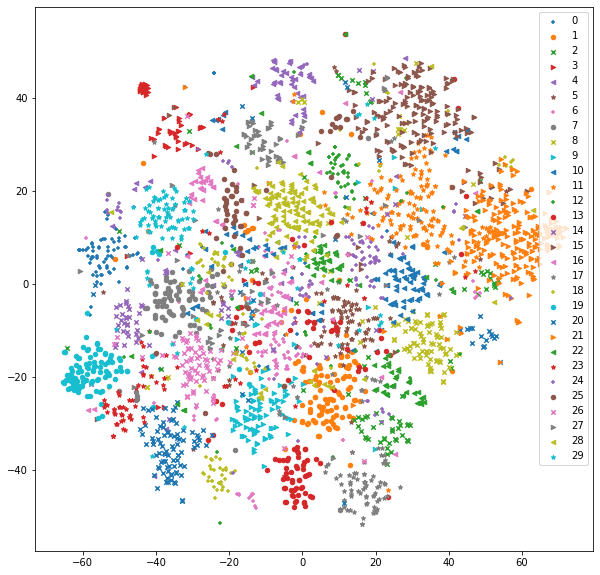

In [6]:
plt.figure(figsize=(10, 10))
markers = ['+', 'o', 'x', '>', '<', '*']
for i, label in enumerate(set(l)):
    idx = np.where(l == label)[0]
    marker = markers[i % len(markers)]
    plt.scatter(z2[idx, 0], z2[idx, 1], label=label, s=20, marker=marker)
plt.legend()

In [77]:
np.array([data['id2word'][i] for i in np.argsort(-plsa.topic_term[1])[:20]])

array(['prom', 'ever', 'ground', 'lord', 'cease', 'back', 'omen',
       'beware', 'later', 'rein', 'man', 'making', 'colour', 'hush',
       'lonely', 'crayon', 'dagger', 'mma', 'put', 'easier'], dtype='<U6')

In [44]:
X.shape

(55860, 10554)

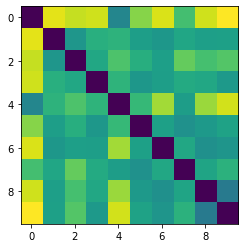

In [38]:
from scipy.spatial.distance import squareform
D = squareform(
    pdist(
        plsa.topic_term,
        lambda p, q: (p * np.log(np.maximum(p, 1e-12) / np.maximum(q, 1e-12))).sum()
    )
)
plt.imshow(D)

<BarContainer object of 10 artists>

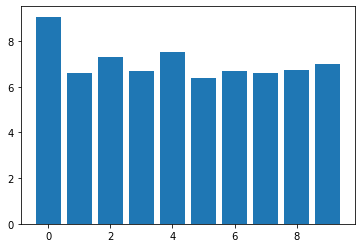

In [39]:
plt.bar(range(D.shape[0]), D.mean(0))

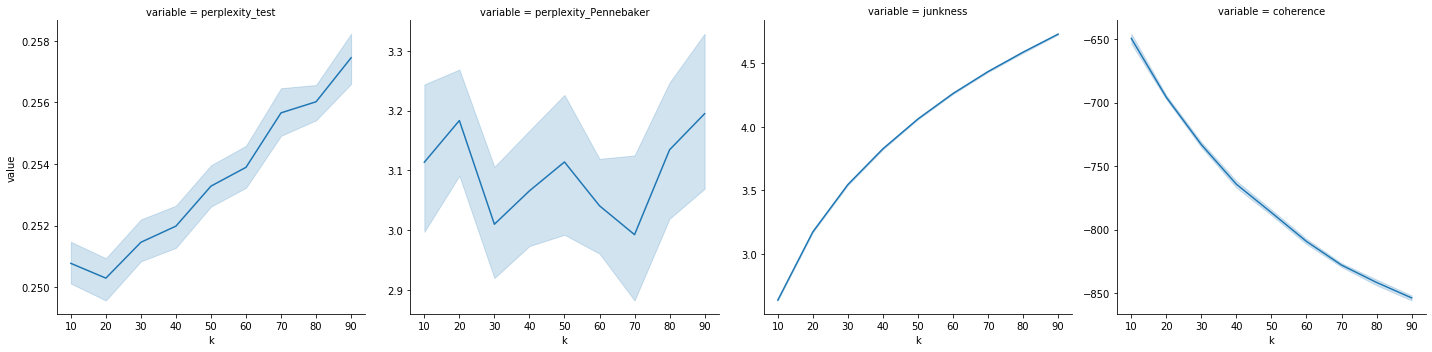

In [70]:
from io import StringIO
df = pd.read_csv(StringIO('''k,trial,perplexity_test,perplexity_Pennebaker,junkness,coherence
10,0,0.2503,3.0858,2.6329,-648.0982
10,1,0.2523,2.9198,2.6359,-645.8976
10,2,0.2534,3.2221,2.6420,-638.9009
10,3,0.2516,3.2238,2.6313,-656.4172
10,4,0.2521,3.1675,2.6394,-655.7942
10,5,0.2503,2.7850,2.6464,-658.1697
10,6,0.2489,3.6772,2.6309,-664.9247
10,7,0.2508,2.9235,2.6381,-657.2206
10,8,0.2524,3.5621,2.6227,-645.2775
10,9,0.2525,3.2049,2.6430,-631.3026
10,10,0.2497,3.0716,2.6326,-650.7646
10,11,0.2514,2.7843,2.6352,-645.3178
10,12,0.2522,3.1679,2.6455,-655.7021
10,13,0.2465,3.4181,2.6475,-640.2861
10,14,0.2492,2.6829,2.6347,-654.5576
10,15,0.2502,2.6290,2.6364,-655.4148
10,16,0.2502,3.4630,2.6338,-646.8434
10,17,0.2505,2.9848,2.6278,-638.6587
10,18,0.2490,3.1437,2.6424,-640.4852
10,19,0.2519,3.1550,2.6384,-659.9264
20,0,0.2491,3.0857,3.1721,-688.1704
20,1,0.2520,2.8164,3.1748,-693.0871
20,2,0.2468,3.3938,3.1817,-694.0685
20,3,0.2480,3.3701,3.1719,-705.3116
20,4,0.2502,3.2376,3.1690,-694.4131
20,5,0.2513,3.0653,3.1972,-698.9251
20,6,0.2501,3.1174,3.1771,-695.7441
20,7,0.2504,2.9553,3.1632,-699.6529
20,8,0.2511,2.8493,3.1717,-693.5542
20,9,0.2523,3.4094,3.1909,-693.8825
20,10,0.2509,3.1923,3.1817,-693.9542
20,11,0.2509,2.7697,3.1719,-695.1123
20,12,0.2476,3.0104,3.1758,-694.1993
20,13,0.2487,3.5265,3.1716,-696.8303
20,14,0.2502,3.2558,3.1575,-698.6704
20,15,0.2497,3.4290,3.1593,-693.5268
20,16,0.2515,3.1909,3.1817,-697.3618
20,17,0.2528,3.3039,3.1778,-693.2927
20,18,0.2509,3.2537,3.1579,-701.8565
20,19,0.2513,3.4341,3.1795,-695.6361
30,0,0.2548,2.6496,3.5477,-731.6569
30,1,0.2527,2.8796,3.5597,-731.3999
30,2,0.2500,3.1595,3.5378,-737.9425
30,3,0.2510,3.2025,3.5474,-730.7805
30,4,0.2511,2.8852,3.5594,-736.3542
30,5,0.2521,3.0412,3.5311,-730.2369
30,6,0.2495,2.8101,3.5762,-730.4945
30,7,0.2522,2.8650,3.5358,-730.7188
30,8,0.2525,2.6524,3.5570,-729.3039
30,9,0.2551,2.8163,3.5420,-734.5369
30,10,0.2516,2.9486,3.5300,-738.8172
30,11,0.2510,3.1890,3.5508,-725.9181
30,12,0.2514,3.0867,3.5295,-735.5138
30,13,0.2504,2.9885,3.5394,-740.2569
30,14,0.2524,2.9336,3.5591,-732.0537
30,15,0.2511,3.3084,3.5517,-732.5727
30,16,0.2511,2.9385,3.5639,-734.2534
30,17,0.2502,3.3151,3.5317,-736.2868
30,18,0.2479,3.1265,3.5314,-741.3751
30,19,0.2510,3.4012,3.5483,-722.2072
40,0,0.2536,3.0884,3.8311,-769.9607
40,1,0.2524,3.3128,3.8461,-769.2572
40,2,0.2540,2.8493,3.8451,-760.9655
40,3,0.2510,3.2885,3.8261,-756.4042
40,4,0.2538,2.8665,3.8231,-765.6665
40,5,0.2535,2.9046,3.8264,-767.9383
40,6,0.2515,3.2673,3.8252,-758.8746
40,7,0.2499,2.8032,3.8443,-763.0035
40,8,0.2524,2.9294,3.8479,-754.9240
40,9,0.2493,3.1247,3.8116,-771.8521
40,10,0.2518,3.2388,3.8288,-774.0345
40,11,0.2522,3.3384,3.8396,-761.0013
40,12,0.2524,3.0630,3.8251,-754.7205
40,13,0.2517,2.6865,3.8357,-769.1599
40,14,0.2519,3.0515,3.8232,-769.6798
40,15,0.2534,2.6511,3.8187,-770.5727
40,16,0.2520,3.1490,3.8119,-767.6944
40,17,0.2477,3.0686,3.8204,-754.0046
40,18,0.2541,3.1033,3.8240,-763.3270
40,19,0.2510,3.5296,3.8070,-762.6265
50,0,0.2568,2.9855,4.0765,-786.5385
50,1,0.2534,2.8649,4.0598,-787.6076
50,2,0.2542,3.2369,4.0622,-792.7714
50,3,0.2550,3.2986,4.0666,-792.7389
50,4,0.2529,3.3441,4.0717,-784.9271
50,5,0.2514,3.3025,4.0706,-786.0771
50,6,0.2539,2.8789,4.0597,-790.8022
50,7,0.2539,3.0767,4.0507,-779.2191
50,8,0.2536,2.9559,4.0805,-781.1798
50,9,0.2536,3.0191,4.0686,-781.0268
50,10,0.2528,2.6630,4.0708,-791.7383
50,11,0.2530,3.1883,4.0638,-786.9945
50,12,0.2526,3.4084,4.0600,-788.2295
50,13,0.2536,3.1249,4.0644,-790.7926
50,14,0.2557,2.6471,4.0449,-789.8032
50,15,0.2518,3.2869,4.0662,-785.2739
50,16,0.2527,2.8397,4.0550,-777.4788
50,17,0.2506,3.1486,4.0555,-794.0572
50,18,0.2504,3.6982,4.0555,-777.2428
50,19,0.2537,3.3124,4.0533,-787.6474
60,0,0.2519,3.1964,4.2575,-810.2865
60,1,0.2555,3.1961,4.2522,-805.1233
60,2,0.2528,2.9603,4.2596,-810.1005
60,3,0.2543,3.0635,4.2578,-813.2925
60,4,0.2564,3.1706,4.2718,-807.4190
60,5,0.2542,2.7867,4.2544,-800.6345
60,6,0.2534,3.2534,4.2533,-807.3769
60,7,0.2508,3.4412,4.2514,-807.1833
60,8,0.2554,3.0001,4.2899,-815.4062
60,9,0.2539,2.8306,4.2725,-806.7775
60,10,0.2543,2.9238,4.2565,-811.0946
60,11,0.2560,3.0334,4.2599,-805.0876
60,12,0.2538,3.0163,4.2633,-803.1708
60,13,0.2526,2.6431,4.2594,-811.2945
60,14,0.2573,3.0621,4.2532,-817.3381
60,15,0.2528,3.0926,4.2533,-813.7349
60,16,0.2525,3.1746,4.2646,-801.9892
60,17,0.2544,2.9281,4.2746,-807.4188
60,18,0.2526,3.1311,4.2732,-815.1248
60,19,0.2529,2.9117,4.2803,-815.9353
70,0,0.2545,2.9247,4.4402,-825.3965
70,1,0.2566,3.1057,4.4458,-834.0326
70,2,0.2539,3.0187,4.4338,-830.9131
70,3,0.2560,2.7506,4.4356,-827.8814
70,4,0.2529,3.6818,4.4140,-830.2095
70,5,0.2566,3.3330,4.4165,-822.6340
70,6,0.2568,3.3923,4.4318,-825.3694
70,7,0.2560,2.8094,4.4430,-829.3800
70,8,0.2526,2.8141,4.4333,-827.3426
70,9,0.2537,2.9393,4.4627,-825.1396
70,10,0.2540,3.2062,4.4411,-827.7910
70,11,0.2559,3.2278,4.4212,-828.8274
70,12,0.2566,2.8297,4.4296,-835.4317
70,13,0.2566,2.7576,4.4286,-822.6063
70,14,0.2541,2.8979,4.4380,-831.6099
70,15,0.2582,2.7588,4.4401,-832.0961
70,16,0.2584,2.7777,4.4347,-825.6868
70,17,0.2560,2.8003,4.4527,-824.5151
70,18,0.2546,3.0822,4.4226,-826.6207
70,19,0.2592,2.7418,4.4460,-824.7778
80,0,0.2571,2.9805,4.5937,-847.5214
80,1,0.2567,2.9014,4.5826,-844.2202
80,2,0.2539,3.8628,4.5898,-841.2104
80,3,0.2542,3.0195,4.5762,-835.0478
80,4,0.2559,3.1362,4.5776,-839.4921
80,5,0.2562,3.1390,4.5736,-834.1601
80,6,0.2540,3.1851,4.6176,-851.7473
80,7,0.2574,2.9295,4.5621,-841.9515
80,8,0.2567,3.0299,4.5789,-847.8025
80,9,0.2561,3.2892,4.5870,-841.4561
80,10,0.2538,2.8861,4.5945,-839.9524
80,11,0.2569,2.7502,4.6021,-851.9343
80,12,0.2583,3.3728,4.6009,-839.9643
80,13,0.2554,2.8588,4.5967,-837.1552
80,14,0.2571,3.0057,4.5954,-835.0493
80,15,0.2550,2.7396,4.5782,-842.8090
80,16,0.2553,3.3086,4.5847,-846.0201
80,17,0.2560,3.4137,4.6207,-833.8481
80,18,0.2562,3.4845,4.5709,-840.7355
80,19,0.2582,3.3951,4.5844,-839.4598
90,0,0.2538,3.6649,4.7319,-854.5018
90,1,0.2582,2.7474,4.7253,-860.7566
90,2,0.2596,3.3923,4.7239,-859.0643
90,3,0.2571,3.3221,4.7257,-853.4918
90,4,0.2564,3.1195,4.7349,-852.9111
90,5,0.2598,2.9487,4.7278,-856.8346
90,6,0.2575,3.0651,4.7245,-860.0844
90,7,0.2549,3.0034,4.7367,-849.1742
90,8,0.2577,3.5940,4.7383,-854.5223
90,9,0.2588,2.7446,4.7437,-862.4450
90,10,0.2574,3.3134,4.7260,-852.3597
90,11,0.2596,3.1012,4.7314,-854.6680
90,12,0.2564,3.0582,4.7331,-849.8731
90,13,0.2549,3.5647,4.7253,-848.3672
90,14,0.2562,3.5739,4.7162,-853.7106
90,15,0.2559,3.5943,4.7171,-844.3736
90,16,0.2573,3.3056,4.7386,-853.3370
90,17,0.2579,3.1863,4.7431,-855.4880
90,18,0.2608,2.7370,4.7343,-852.7679
90,19,0.2588,2.8588,4.7306,-845.8828
'''))

import seaborn as sns

df = pd.melt(df, id_vars=['k', 'trial'])
sns.relplot(
    data=df, x='k', y='value', col='variable',
    kind='line',
    facet_kws={'sharey': False, 'sharex': True}
)

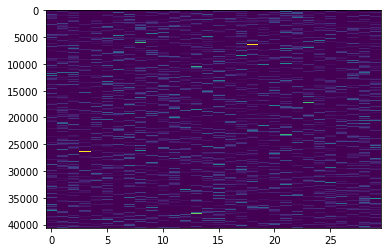

In [35]:
plt.imshow(Z, aspect='auto')

In [44]:
tracks_ = tracks.set_index(0)
metadata = []
for i in z_idx:
    mxm_tid = raw_data[i][0]
    tid = mxm2msd[mxm_tid]
    row = tracks_.loc[tid]
    artist, title = row[2], row[3]
    metadata.append([artist, title, str(np.argmax(Z[i]))])

In [28]:
artist

'Blackalicious / Gil Scott-Heron'

In [45]:
dump_embeddings('/hdd/data/embedding_values.tsv', z, metadata, ['artist', 'title', 'topic'])